# Libraries

Import your libraries

In [47]:
import numpy as np
import pandas as pd
import statistics as cal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix

In [48]:
Player = 15
Game = 2

df = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

print(df.Action[df.Action == "Sprinting"])

Series([], Name: Action, dtype: float64)


# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [49]:
#Load the DataFrame in df

Player = 15
Game = 2

df = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

#------------------------------------------------------------------------------------------------------

# Replace NaN values for 0

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

#--------------------------------------------------------------------------------------------------------

#If df.Action has the value 'sprinting', it replaces it for the value 1

df.Action[df.Action == "Sprinting"] = 1

#---------------------------------------------------------------------------------------------------------

#Delete first 99 rows, so df starts at timeLine == 1.00

df = df.iloc[99: , :]

<ipython-input-49-1ca778e572d0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Action[df.Action == "Sprinting"] = 1


# Preparing Data

Split the Dataframe in chunks of n/100 seconds. Combine to 1 dataframe. With Sum,Div and Action split into Train and Valid/Test. 

In [50]:
#Convert data into chunks of a second
n = 100 #chunk size (100 datapoints in one second)
chunks = [df[i:i+n] for i in range(0,df.shape[0],n)]

#----------------------------------------------------------------------------------------------------------------
count = 0
#Set chunks into dataframe
#for chunk in chunks:
frames = []
for chunk in chunks:
    P = pd.DataFrame({'frAcc':[max(chunk['frAcc'].tolist())], 
                      'frRoAcc':[chunk['frRoAcc'].tolist()], 'frDispl':[chunk['frDispl'].tolist()], 
                      'frRoAng':[chunk['frRoAng'].tolist()], 'frSpeed':[max(chunk['frSpeed'].tolist())], 
                      'timeLine':[max(chunk['timeLine'].tolist())], 'frameRotationalSpeedX':[chunk['frameRotationalSpeedX'].tolist()], 
                      'frameRotationalSpeedY':[cal.mean(chunk['frameRotationalSpeedY'].tolist())], 'frameRotationalSpeedZ':[cal.mean(chunk['frameRotationalSpeedZ'].tolist())],
                      'wheelRotationalSpeedX':[max(chunk['wheelRotationalSpeedX'].tolist())], 'wheelRotationalSpeedY':[chunk['wheelRotationalSpeedY'].tolist()],
                      'wheelRotationalSpeedZ':[chunk['wheelRotationalSpeedZ'].tolist()], 'frRoSpeed':[max(chunk['frRoSpeed'].tolist())],
                      'Sum_WheelX_FrameZ':[max(chunk['Sum_WheelX_FrameZ'].tolist())], 'Div_FrameZ_WheelX':[cal.mean(chunk['Div_FrameZ_WheelX'].tolist())],
                      'Filt_WheelX':[cal.mean(chunk['Filt_WheelX'].tolist())], 'Filt_FrameZ':[cal.mean(chunk['Filt_FrameZ'].tolist())],
                      'Action':[max(chunk['Action'].tolist())]})
    #count += 1
    #print(count)      #    as we are working with some values removed and also max values we have less values
    frames.append(P)
df = pd.concat(frames,ignore_index=True)

In [51]:
# split chunk data into train test validate (with colum [sum and Div] as input, and action as output)
X_train, X_test, y_train, y_test = train_test_split(df[[
                                                        'Sum_WheelX_FrameZ',
                                                        'Div_FrameZ_WheelX',
                                                        'wheelRotationalSpeedX',
                                                        'Filt_FrameZ',
                                                        'Filt_WheelX',
                                                        'frameRotationalSpeedY'
                                                       ]], #these are the features
                                                    df.Action, test_size = 0.2, random_state=42)

In [76]:
sgdc = SGDClassifier(loss='hinge', penalty='l2', max_iter=1, tol=0.05)
print(sgdc)
 
sgd = sgdc.fit(X_train, y_train)

score = sgdc.score(X_train, y_train)
print("Training score: ", score) 

SGDClassifier(max_iter=1, tol=0.05)
Training score:  0.6430335609472614


/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [77]:
#sgdc = SGDClassifier(loss='--------------', max_iter=10000, tol=0.05)

#hinge->0.35958157780037775
#modified_huber->0.3604532907162574
#log->0.4464622984163882
#squared_error->DOESN'T WORK
#huber->0.3591457213424379
#epsilon_insensitive->0.641144849629522
#squared_epsilon_insensitive->0.6409995641435421

# Validation

0.0737410071942446    0.25949367088607594


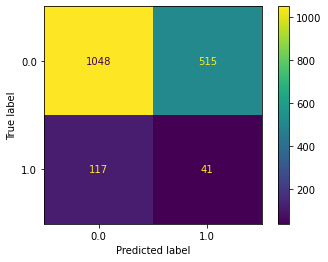

In [78]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

test_predictions = sgd.predict(X_test)

# Create precision or recall score based on the metric you imported
score1 = precision_score(y_test, test_predictions)
score2 = recall_score(y_test, test_predictions)
print(score1, '  ', score2)
#Precision: Ensures you don't over predict positive values.
#Recall: Ensures you don't miss any positive values.

X = df[['Sum_WheelX_FrameZ', 
        'Div_FrameZ_WheelX', 
        'wheelRotationalSpeedX', 
        'Filt_FrameZ', 
        'Filt_WheelX', 
        'frameRotationalSpeedY']], #these are the features
y = df.Action



#Confusion Matrix
plot_confusion_matrix(sgd, X_test, y_test)
plt.show()

In [79]:
classes = ['Not Sprinting', 'Sprinting']
y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred, target_names=classes))
#Precision	Ratio of true positives to the sum of true and false positives.

#Recall	Ratio of true positives to the sum of true positives and false negatives.

#F1 Score	The F1 is the weighted harmonic mean of precision and recall. 
#The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.

#Support	Support is the number of actual occurrences of the class in the dataset. 
#It doesn’t vary between models, it just diagnoses the performance evaluation process.

               precision    recall  f1-score   support

Not Sprinting       0.90      0.67      0.77      1563
    Sprinting       0.07      0.26      0.11       158

     accuracy                           0.63      1721
    macro avg       0.49      0.46      0.44      1721
 weighted avg       0.82      0.63      0.71      1721



# Tuning

In [70]:
#CROSS-VALIDATION
X = df[['Sum_WheelX_FrameZ', 
        'Div_FrameZ_WheelX', 
        'wheelRotationalSpeedX', 
        'Filt_FrameZ', 
        'Filt_WheelX', 
        'frameRotationalSpeedY']] #these are the features
y = df.Action



from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(sgd, X.to_numpy(), y, cv=4 )
cv_scores#gives predictions of each split

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

array([0.43840074, 0.61273826, 0.29986053, 0.68619247])

In [71]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X, y)

In [72]:
grid_param = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1],  
             'loss':['hinge', 'log', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty':['l1','l2'], 'class_weight':['balanced']}

searcher = GridSearchCV(sgd, grid_param, cv=10)
searcher.fit(X_train, y_train)



#hinge->0.35958157780037775
#modified_huber->0.3604532907162574
#log->0.4464622984163882
#squared_error->DOESN'T WORK
#huber->0.3591457213424379
#epsilon_insensitive->0.641144849629522
#squared_epsilon_insensitive

#gd_sr = GridSearchCV(estimator=sgd, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)

#gd_sr.fit(X_train, y_train)

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum

GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     loss='squared_epsilon_insensitive',
                                     max_iter=1, n_jobs=8, penalty='l1',
                                     tol=0.05),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'log', 'huber',
                                  'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l1', 'l2']})

In [73]:
#Here  I print results because i can't see it in the block above
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best CV params {'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'huber', 'penalty': 'l1'}
Best CV accuracy 0.5624436746886285
Test accuracy of best grid search hypers: 0.6368390470656595


/opt/jupyterhub/anaconda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(class_weight='balanced', loss='squared_epsilon_insensitive',
              max_iter=1, n_jobs=8, penalty='l1', tol=0.05)


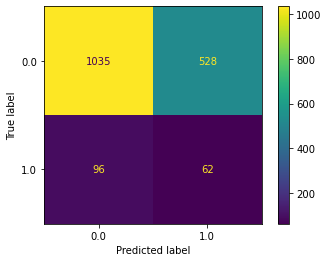

In [74]:
sgdc = SGDClassifier(alpha = 0.0001, loss='squared_epsilon_insensitive', penalty='l1', max_iter=1, tol=0.05, n_jobs=8, class_weight='balanced')
print(sgdc)#class_weight='balanced' => Balances the data from the model
 
sgd = sgdc.fit(X_train, y_train)

score = sgdc.score(X_train, y_train)


plot_confusion_matrix(sgd, X_test, y_test)
plt.show()